<div style="background-color:powderblue;">
Dado que soy nuevo en la inmobiliaria, lo primero que haría sería reunirme con los tasadores y aprovechar todo su conocimiento y experiencia en la valuación de propiedades. 

    
</br>Asumiendo que ya posee el conocimiento del negocio, y teniendo en cuenta el problema que debemos resolver **"Valuar propiedades"**, acordamos que los principales factores que influyen en una valuación son:
<ul>
  <li><b>Ubicación:</b> La ubicación en la que se encuentra la ubicación es un factor determinante en su valuación</li>
    <li><b>Superficie total de la propiedad:</b> La superficie del terreno, ya sea cubierta o no</li>
    <li><b>Superficie cubierta:</b> Superficie cubierta, en m2 que ocupa la construcción</li>
    <li><b>Nro de habitaciones:</b> Cantidad de habitaciones</li>    
    <li><b>Nro de baños:</b> Cantidad de baños</li>      
    <li><b>Nro. de cocheras:</b> Si posee o no cocheras y su capacidad (uno, dos vehículos)</li>
    <li><b>Tipo de propiedad:</b> Casa, departamento, etc</li>    
    <li><b>Mercado:</b> El mercado puede fluctuar y esto puede hacer que el valor de una misma propiedad cambie en determinados momentos</li>    
</ul> 
</div>

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

# Cargamos los datos

In [2]:
propiedades = pd.read_csv('DS_Proyecto_01_Datos_Properati.csv',parse_dates=['start_date','end_date','created_on'])
filas, columnas = propiedades.shape
print('Nuestro dataset tiene', filas,'filas y',columnas,'columnas')


Nuestro dataset tiene 146660 filas y 19 columnas


In [3]:
propiedades.replace('9999-12-31',pd.NA,inplace=True)
propiedades.end_date = propiedades.end_date.astype('datetime64')

# Valores faltantes

In [6]:
propiedades.isna().sum().sort_values(ascending=False)

end_date           25101
surface_covered    21614
surface_total      20527
lon                 9959
lat                 9925
bathrooms           5957
operation_type         0
l3                     0
created_on             0
l1                     0
l2                     0
bedrooms               0
rooms                  0
property_type          0
price                  0
currency               0
title                  0
description            0
start_date             0
dtype: int64

# Estadasticos básicos de nuestros datos

In [10]:
propiedades_final = propiedades[propiedades['property_type'].isin(['Departamento', 'Casa','PH']) &
                               propiedades['l2'].isin(['Capital Federal'])].copy()

variables = ['rooms','bedrooms','bathrooms','surface_total','surface_covered','price','property_type']
propiedades_final = propiedades_final[variables]
propiedades_final.describe()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,91485.000000,91485.000000,89314.000000,82568.000000,82250.000000,9.148500e+04
mean,2.964278,1.960278,1.560147,112.626369,94.966310,2.595003e+05
std,1.314704,1.072946,0.860309,980.713664,778.515243,3.222654e+05
min,1.000000,0.000000,1.000000,10.000000,1.000000,6.000000e+03
25%,2.000000,1.000000,1.000000,49.000000,44.000000,1.200000e+05
50%,3.000000,2.000000,1.000000,71.000000,63.000000,1.750000e+05
75%,4.000000,3.000000,2.000000,111.000000,96.000000,2.790000e+05
max,26.000000,15.000000,14.000000,126062.000000,126062.000000,3.243423e+07


### Algunas funciones que utilizamos para realizar el análisis y manipulación de los datos

In [11]:
def descartar_registros(df, condicion,variable,descripcion):
    '''
    Esta función se utiliza para descartar registros del df principal
    y moverlos a un df de descartados, indicando el motivo por el cual
    fue descartado.
    parametros:
    condición: mascara que debe aplicarse al df
    variable: que varibale estamos evaluando
    descripción: texto que indique el motivo por el cual fue descartado
    retorno:
    devuelve un df con los registros descartados
    '''
    propiedades_descartadas_tmp = df.loc[condicion].copy()
    propiedades_descartadas_tmp['variable'] = variable
    propiedades_descartadas_tmp['motivo'] = descripcion
    df.drop(propiedades_descartadas_tmp.index, inplace=True,axis=0)

    return propiedades_descartadas_tmp

# inicializamos 
propiedades_descartadas = pd.DataFrame(columns=propiedades_final.columns.to_list()).copy()
propiedades_descartadas['variable'] = ''
propiedades_descartadas['motivo'] = ''

In [12]:
def analisis_variables(df, variable,variable_texto):
    f, axes = plt.subplots(1,2, figsize=(20, 4), sharex=True)
    sns.distplot(df[variable], ax=axes[0], kde=False)
    axes[0].set(xlabel='Cantidad de '+variable_texto, ylabel='Cantidad de instancias')
    sns.boxplot(data=df,x=variable,y='property_type')
    axes[1].set(xlabel='Cantidad de '+variable_texto, ylabel='Tipo de propiedad')

    plt.show()

# Filtramos/limpiamos nuestros datos

In [14]:
# quitamos los NA
condicion = propiedades_final.bathrooms.isna()
propiedades_descartadas = pd.concat([propiedades_descartadas, descartar_registros(propiedades_final, condicion,'bathrooms','Descartado por dato faltante')])
condicion = propiedades_final.surface_total.isna()
propiedades_descartadas = pd.concat([propiedades_descartadas, descartar_registros(propiedades_final, condicion,'surface_total','Descartado por dato faltante')])
condicion = propiedades_final.surface_covered.isna()
propiedades_descartadas = pd.concat([propiedades_descartadas, descartar_registros(propiedades_final, condicion,'surface_covered','Descartado por dato faltante')])

# quitamos superficie menor a 15 o superior a 100
condicion = propiedades_final.surface_total < 15 
propiedades_descartadas = pd.concat([propiedades_descartadas, descartar_registros(propiedades_final, condicion,'surface_covered','Inferior a 15 o superior a 1000')])
condicion = propiedades_final.surface_total > 1000
propiedades_descartadas = pd.concat([propiedades_descartadas, descartar_registros(propiedades_final, condicion,'surface_covered','Inferior a 15 o superior a 1000')])

# quitamos precios superiores a 4000000
condicion = propiedades_final.price > 4000000 
propiedades_descartadas = pd.concat([propiedades_descartadas, descartar_registros(propiedades_final, condicion,'price','Precio superior a 4000000')])

In [16]:
propiedades_final.shape

(81019, 7)

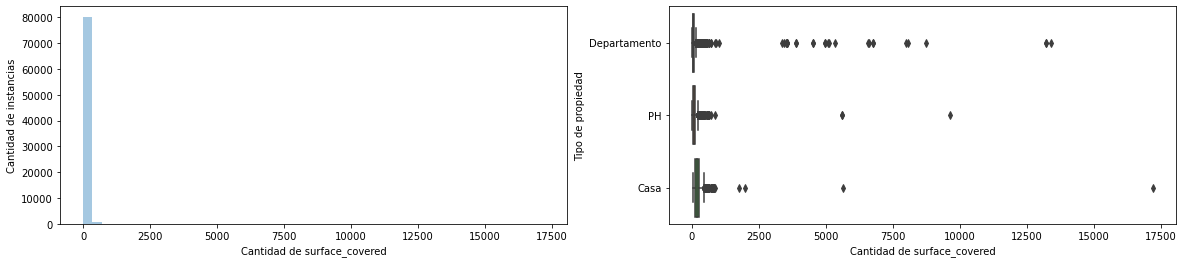

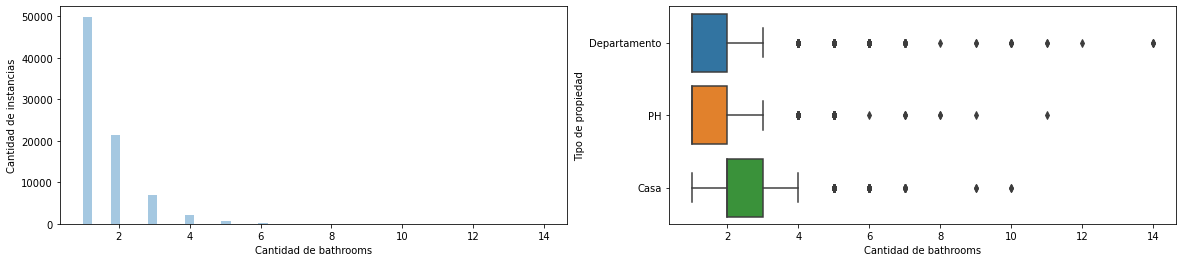

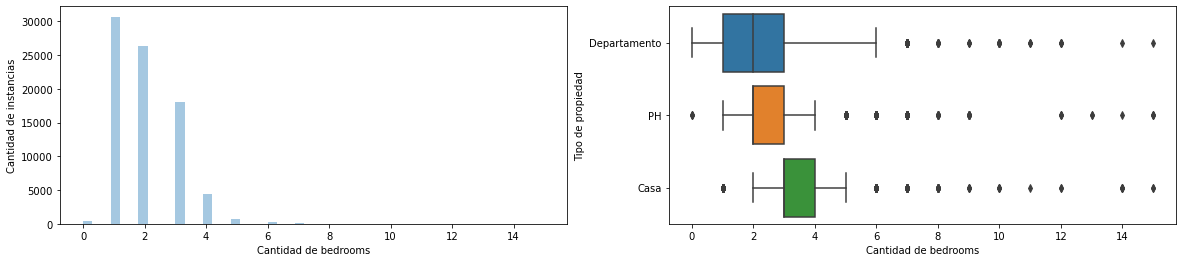

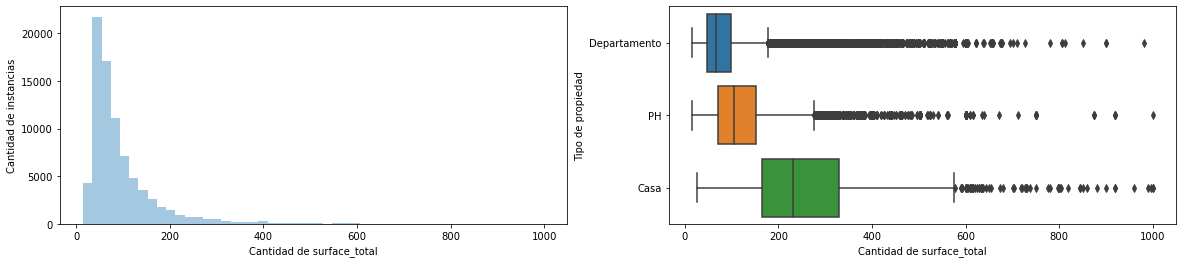

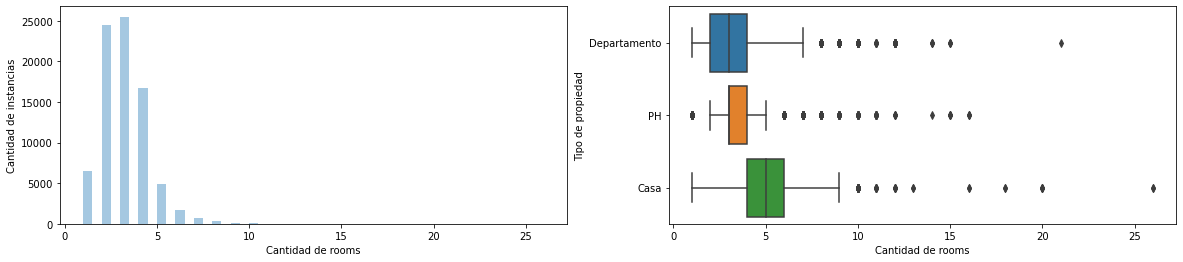

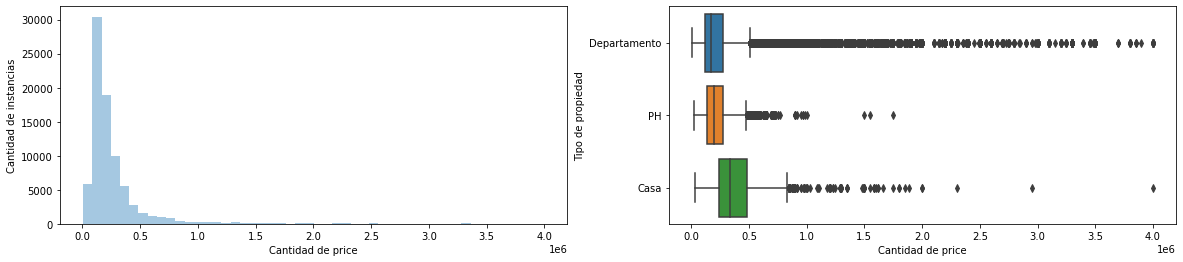

In [15]:
for v in set(variables) - {'property_type'}:
    analisis_variables(propiedades_final, variable=v,variable_texto=v)

In [19]:
propiedades_final[propiedades_final['surface_total'] < propiedades_final['surface_covered']].shape

(743, 7)

# existen 743 datos con superficie cubierta superior a superficie total.. los descarto

In [21]:
condicion = propiedades_final.surface_total < propiedades_final.surface_covered
propiedades_descartadas = pd.concat([propiedades_descartadas, descartar_registros(propiedades_final, condicion,'surface_covered','Superficie cuvierta superior a superficie total')])

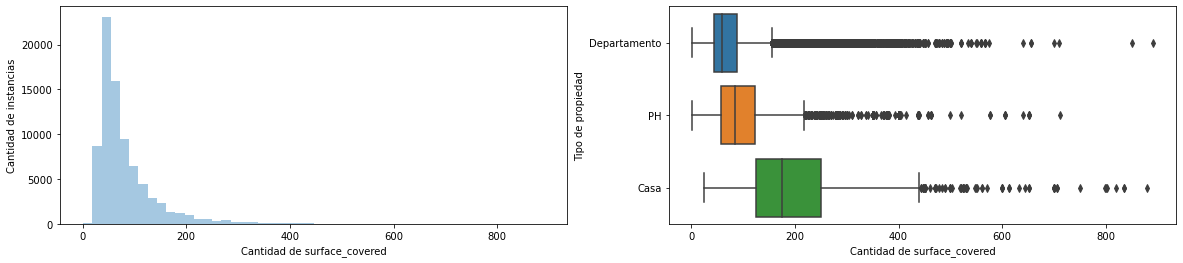

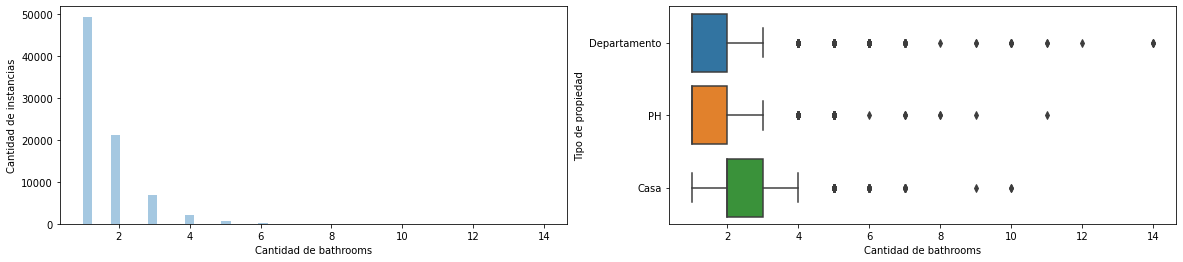

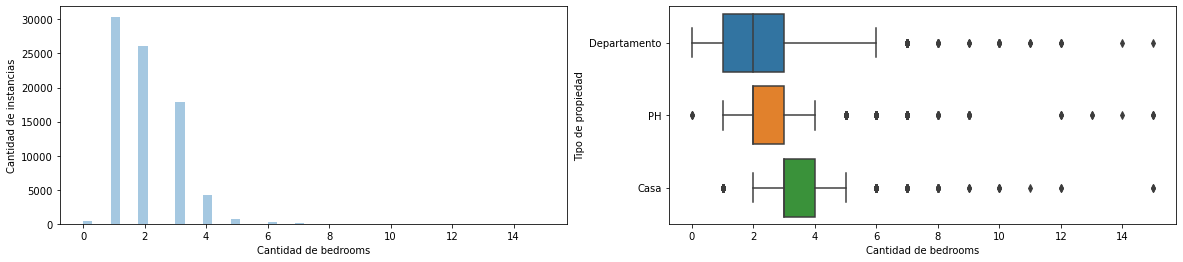

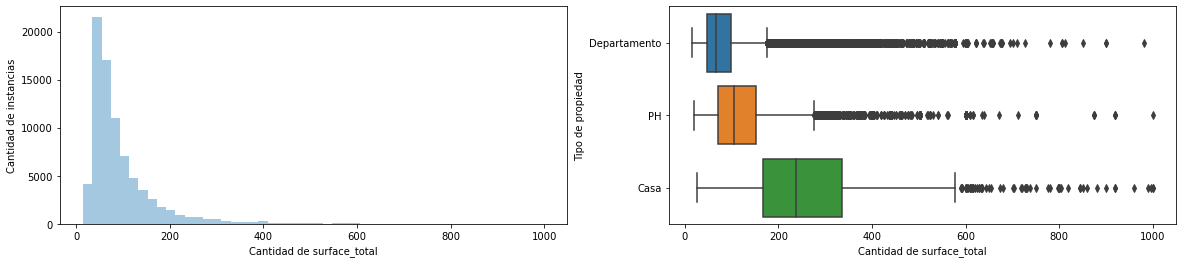

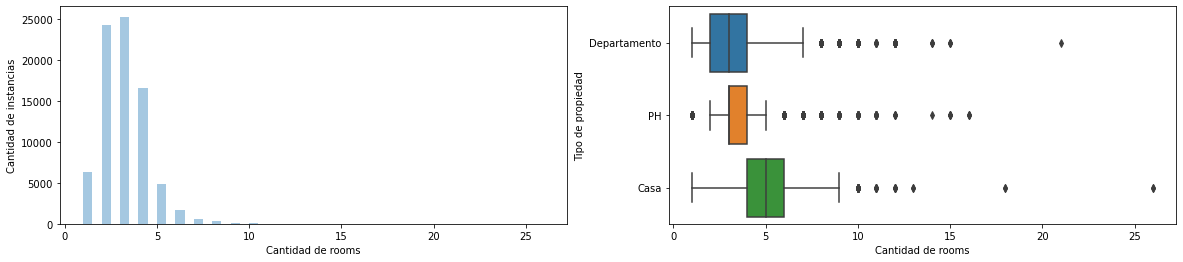

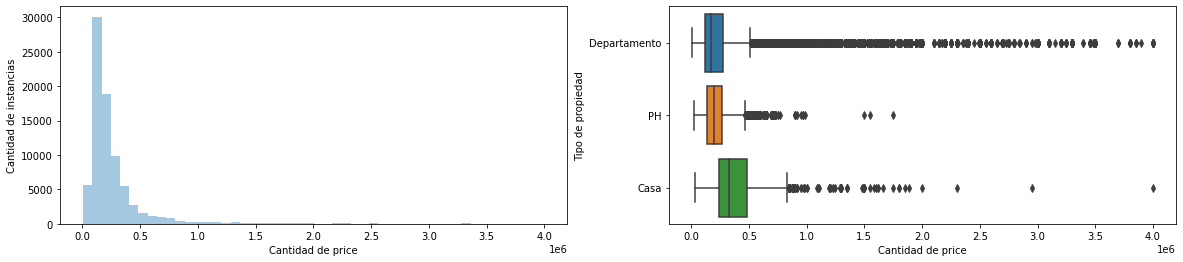

In [22]:
for v in set(variables) - {'property_type'}:
    analisis_variables(propiedades_final, variable=v,variable_texto=v)

# Relaciones entre las distintas variables

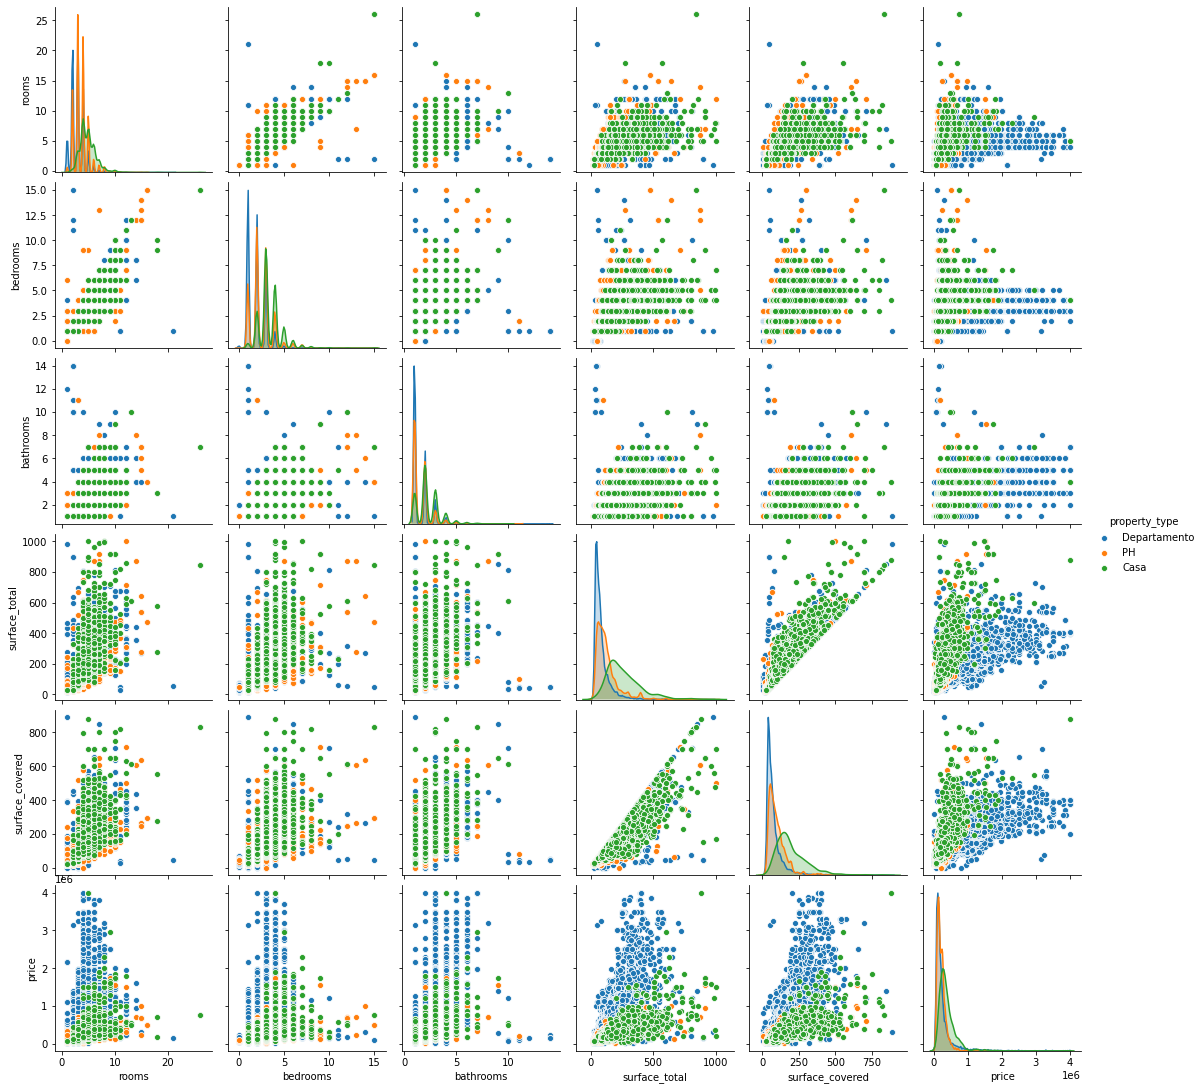

In [24]:
sns.pairplot(data=propiedades_final,hue='property_type')

# correlacion

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
rooms,1.000000,0.925161,0.600235,0.727318,0.762009,0.481131
bedrooms,0.925161,1.000000,0.603132,0.695650,0.727051,0.442554
bathrooms,0.600235,0.603132,1.000000,0.649880,0.695146,0.638297
surface_total,0.727318,0.695650,0.649880,1.000000,0.931365,0.686423
surface_covered,0.762009,0.727051,0.695146,0.931365,1.000000,0.749829
price,0.481131,0.442554,0.638297,0.686423,0.749829,1.000000


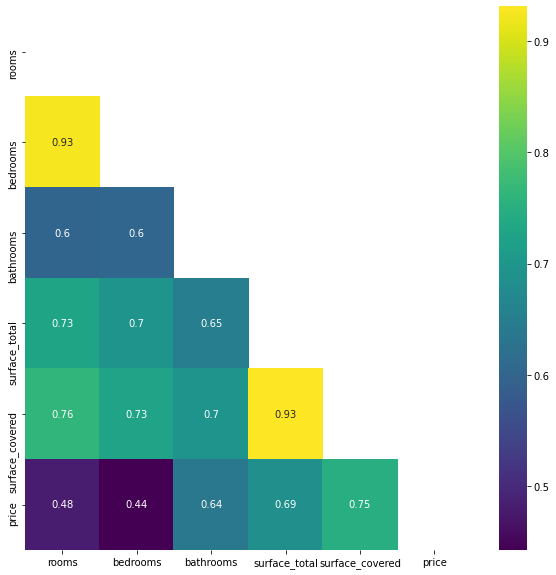

In [25]:
plt.figure(figsize=(10,10))
matrix = np.triu(propiedades_final.corr())
sns.heatmap(propiedades_final.corr(),cmap='viridis',mask=matrix, annot = True)
propiedades_final.corr()


<div style="background-color:powderblue;">
Si obvervaciones la correlación por tipo de propiedad vemos:
</div>   

|Departamento||PH||Casa||
|----|---|---|--|--|--|
|surface_covered|0.829837|surface_covered|0.755795|surface_covered|0.704272|
|bathrooms|0.646040|rooms|0.583769|bathrooms|0.521528|
|rooms|0.512115|bathrooms|0.579115|rooms|0.413498|
|bedrooms|0.472815|bedrooms|0.570934|bedrooms|0.365084|
|surface_total|0.284759|surface_total|0.250230|surface_total|0.282713|


<div style="background-color:powderblue;">
Pregunta planteada: como varía el valor por metro de construccion por metro cuadrado cubierto de acuerdo al tipo de propiedad?
</div>   


In [27]:
df_tmp = propiedades_final[['property_type','price','surface_covered']].groupby('property_type').sum()
df_tmp['precio_por_metro_cubierto'] = df_tmp['price'] / df_tmp['surface_covered']
df_tmp[['precio_por_metro_cubierto']].sort_values(by='precio_por_metro_cubierto',  ascending=False)

,precio_por_metro_cubierto
property_type,
Departamento,3497.271920
PH,2200.219671
Casa,1959.454839


# Machine Learning

### modelo benchmark KNN

In [32]:

# Separamos en variables predictoras (X) y la variable objetivo (y)
X = propiedades_final[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']]
y = propiedades_final['price']

# Separamos los datos en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30, random_state=1975)
knn_regressor = KNeighborsRegressor(n_neighbors=5)
knn_regressor.fit(X_train, y_train)
# Predecimos
y_pred_train = knn_regressor.predict(X_train)
y_pred_test = knn_regressor.predict(X_test)
# calculamos el error

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
print(f'Raíz del error cuadrático medio en Test: {rmse_test}')

Raíz del error cuadrático medio en Train: 119890.74233937754
Raíz del error cuadrático medio en Test: 156315.01518570242


## buscamos optimizar los hiperparametros para un modelo KNN

In [68]:
resultados = []
metricas = ['euclidean','manhattan','chebyshev','minkowski']
n_vecinos_lista = [1,2,3,4,5,6,7,8,9,10,12,14,16,20,40,100]
for n_vecinos in n_vecinos_lista:
    for metrica in metricas:
        knn_regressor = KNeighborsRegressor(n_neighbors=n_vecinos,metric=metrica)
        knn_regressor.fit(X_train, y_train)
        y_pred_train = knn_regressor.predict(X_train)
        y_pred_test = knn_regressor.predict(X_test)
        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        resultados.append(['KNN',metrica,n_vecinos,rmse_train,rmse_test])
    

## buscamos optimizar los hiperparametros para un modelo arbol

In [69]:
profundidades = [1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,50]
criterion = ['mse','mae','friedman_mse']
for profundidad in profundidades:
    for c in criterion:
        tree_regressor = DecisionTreeRegressor(max_depth=profundidad, criterion=c,random_state=42)
        tree_regressor.fit(X_train, y_train)
        y_pred_train = tree_regressor.predict(X_train)
        y_pred_test = tree_regressor.predict(X_test)
        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        resultados.append(['TreeRegressor',c,profundidad,rmse_train,rmse_test])
    

In [88]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_train = linear_model.predict(X_train)
y_pred_test = linear_model.predict(X_test)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
resultados = resultados.append({'Modelo':'LinearRegressor','Metrica':'NA','Nro. de vecinos':'NA','rmse_train':rmse_train,'rmse_test':rmse_test},ignore_index=True)

In [ ]:
resultados = pd.DataFrame(resultados)
resultados.rename({0:'Modelo',1:'Metrica',2:'Nro. de vecinos',3:'rmse_train',4:'rmse_test'},axis=1,inplace=True)

In [97]:
resultados.sort_values(by='rmse_test',ignore_index=True,inplace=True)

In [98]:
resultados.head(10)

,Modelo,Metrica,Nro. de vecinos,rmse_train,rmse_test
0,TreeRegressor,friedman_mse,15,71495.231426,144566.943818
1,TreeRegressor,friedman_mse,40,54204.692666,144578.977102
2,TreeRegressor,friedman_mse,35,54204.692666,144578.977102
3,TreeRegressor,friedman_mse,50,54204.692666,144578.977102
4,TreeRegressor,mse,50,54204.692666,146492.768095
5,TreeRegressor,mse,35,54204.692666,146492.768095
6,TreeRegressor,mse,40,54204.692666,146492.768095
7,TreeRegressor,friedman_mse,20,57529.907490,146853.924189
8,TreeRegressor,mse,15,71495.231426,147070.723148
9,TreeRegressor,mse,20,57529.907490,147178.825938


In [99]:
resultados[resultados['Modelo']=='KNN'].head(10)

,Modelo,Metrica,Nro. de vecinos,rmse_train,rmse_test
21,KNN,manhattan,5,119647.906659,152099.088333
25,KNN,manhattan,4,112737.018860,152829.105737
27,KNN,euclidean,3,102825.337323,153264.891575
28,KNN,minkowski,3,102825.337323,153264.891575
29,KNN,manhattan,3,102159.263874,153289.138064
30,KNN,euclidean,4,112778.555605,153775.734569
31,KNN,minkowski,4,112778.555605,153775.734569
32,KNN,minkowski,2,89480.162741,153962.290917
33,KNN,euclidean,2,89480.162741,153962.290917
34,KNN,manhattan,2,90185.494475,155290.606768


In [100]:
resultados[resultados['Modelo']=='LinearRegressor'].head(10)

,Modelo,Metrica,Nro. de vecinos,rmse_train,rmse_test
100,LinearRegressor,NA,NA,183687.486079,183670.844616


# Registros descartados, para enviar analizar

In [101]:
propiedades_descartadas.head()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type,variable,motivo
351,1.0,1.0,NaN,23.0,23.0,72000.0,Departamento,bathrooms,Descartado por dato faltante
360,1.0,1.0,NaN,14.0,14.0,27000.0,Departamento,bathrooms,Descartado por dato faltante
438,4.0,3.0,NaN,88.0,88.0,192000.0,Departamento,bathrooms,Descartado por dato faltante
573,2.0,1.0,NaN,25.0,23.0,70000.0,Departamento,bathrooms,Descartado por dato faltante
614,1.0,0.0,NaN,38.0,32.0,85000.0,Departamento,bathrooms,Descartado por dato faltante


In [108]:
propiedades_descartadas.groupby(by=['variable','motivo']).size()

variable         motivo                                         
bathrooms        Descartado por dato faltante                       2171
price            Precio superior a 4000000                            32
surface_covered  Descartado por dato faltante                        474
                 Inferior a 15 o superior a 1000                     159
                 Superficie cuvierta superior a superficie total     743
surface_total    Descartado por dato faltante                       7630
dtype: int64

In [107]:
propiedades_descartadas.to_csv('registros_descartados.csv')